<a href="https://www.kaggle.com/code/iqmansingh/gun-knife-detection-yolov5-fasterrcnn?scriptVersionId=136770986" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#F8E2CF;
           font-size:120%;
           font-family:Verdana;
           text-align:center;
           letter-spacing:0.5px">
<h1 style="padding: 25px;color:black;">YOLOv5s</h1>
</div>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('dark_background')

# Setup

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install
!wandb disabled 

import torch
import utils
display = utils.notebook_init()  # checks

# Train YOLOv5s on Custom Dataset

In [ ]:
# Train YOLOv5s on Guns & Knives Dataset for 10 epochs
!python train.py --img 640 --batch 8 --epochs 10 --data /kaggle/input/guns-knives-object-detection/guns-knives-yolo/guns-knives-yolo/data.yaml --weights yolov5s.pt --cache

In [ ]:
# !zip -r /kaggle/working/last_run.zip /kaggle/working/yolov5/yolov5/runs/train/exp3

In [ ]:
# !python export.py --weights /kaggle/working/yolov5/yolov5/runs/train/exp3/weights/best.pt 

# Detect
```
python detect.py --source 0  # webcam
                          img.jpg  # image
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

In [ ]:
!python detect.py --weights /kaggle/working/yolov5/yolov5/runs/train/exp2/weights/best.pt --img 640 --conf 0.25 --source /kaggle/input/guns-knives-object-detection/guns-knives-yolo/guns-knives-yolo/test/images/ABsframe00214_jpg.rf.ae6c1e7d4c8e474123569e8bfa08f701.jpg


# Saving & Reusing Best Weights (best.pt)

In [ ]:
import torch
import PIL

In [ ]:
model = torch.hub.load('','custom', path='/kaggle/working/yolov5/yolov5/runs/train/exp2/weights/best.pt',force_reload=True,source='local')
im1 = model("/kaggle/input/guns-knives-object-detection/guns-knives-yolo/guns-knives-yolo/test/images/ABsframe00214_jpg.rf.ae6c1e7d4c8e474123569e8bfa08f701.jpg")
im2 = model("/kaggle/input/guns-knives-object-detection/guns-knives-yolo/guns-knives-yolo/test/images/DefenseKnifeAttack0898_jpg.rf.7bb618a37cc2fe0a9178105fda35c3bf.jpg")
im1.show() # or .show(), .save(), .crop(), .pandas(), etc.
im2.show()


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.subplot(1,2,1)
img = mpimg.imread("/kaggle/working/yolov5/runs/detect/exp3/DefenseKnifeAttack0093_jpg.rf.8d998dae5f0fabb1cd0264e83818327d.jpg")
imgplot = plt.imshow(img)
plt.axis('off') 

plt.subplot(1,2,2)
img = mpimg.imread("/kaggle/working/yolov5/runs/detect/exp5/ABsframe00214_jpg.rf.ae6c1e7d4c8e474123569e8bfa08f701.jpg")
imgplot = plt.imshow(img)
plt.axis('off')

plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#F8E2CF;
           font-size:120%;
           font-family:Verdana;
           text-align:center;
           letter-spacing:0.5px">
<h1 style="padding: 25px;color:black;">FasterRCNN MobileNet v3</h1>
</div>

# Setup

In [1]:
!pip install torch
!pip install torchvision
!pip install pycocotools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2

print(torch.__version__)
print(torchvision.__version__)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=93593 sha256=66cc8e737a0f834a42e112f644ab5496f61c0f0114b599f90238f53f287b64b8
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools
2.0.0
0.15.1


In [2]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), 
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

class DatasetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] 
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ 
    def __len__(self):
        return len(self.ids)

# Importing Dataset

In [3]:
dataset_path = "/kaggle/input/guns-knives-object-detection/guns-knives-coco/guns-knives-coco"
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]
classes

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


['weapon', 'knife', 'pistol']

In [4]:
train_dataset = DatasetDetection(root=dataset_path, split='train', transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


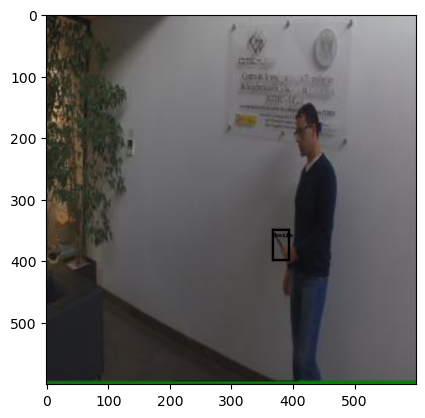

In [5]:
sample = train_dataset[23]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

# Model

In [6]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 91.2MB/s]


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [8]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)
device = torch.device("cuda")
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [9]:
def train_one_epoch(model, optimizer, loader, device, epoch, history):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) 
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    history.append(all_losses_dict)
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [10]:
num_epochs=1
history = []

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, history)

100%|██████████| 1098/1098 [02:20<00:00,  7.81it/s]

Epoch 0, lr: 0.010000, loss: 0.414571, loss_classifier: 0.168958, loss_box: 0.180293, loss_rpn_box: 0.028006, loss_object: 0.037314


In [13]:
torch.save(model,"/kaggle/working/frcnn-mobilenetv3.pt")

In [14]:
loadedModel = torch.load("/kaggle/working/frcnn-mobilenetv3.pt")

In [15]:
loadedModel.eval()
torch.cuda.empty_cache()

In [16]:
test_dataset = DatasetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


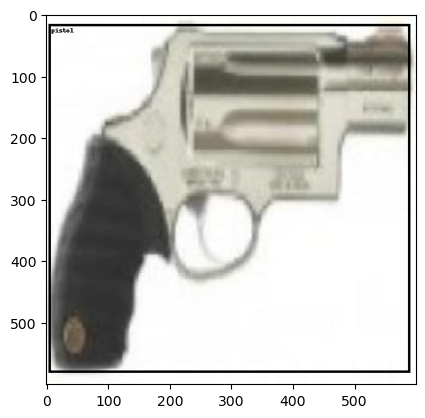

In [17]:
sample = test_dataset[20]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

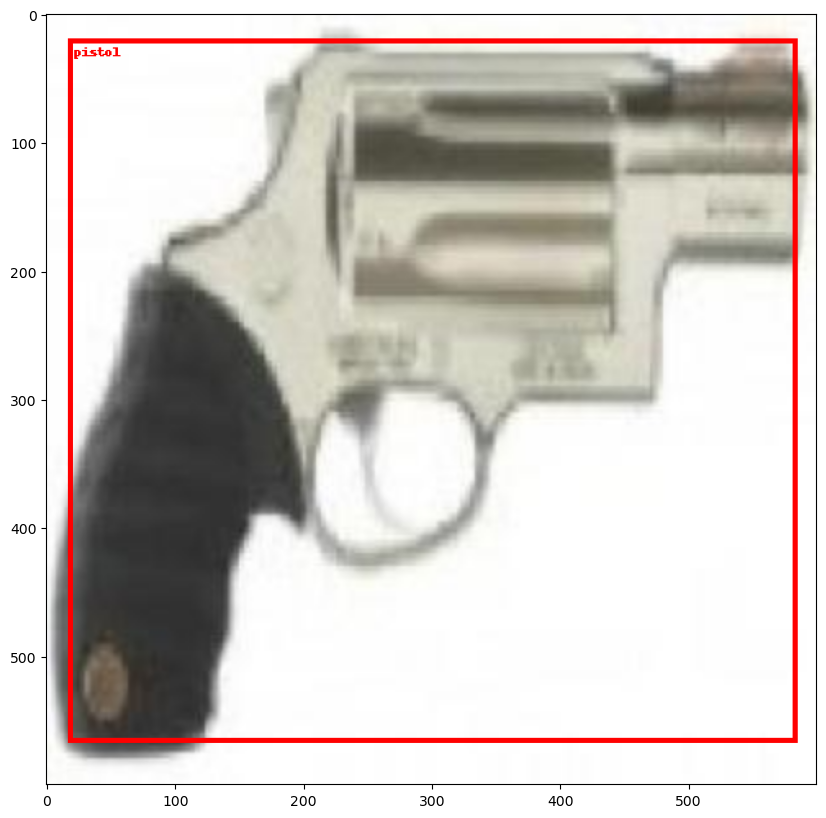

In [18]:
img, _ = test_dataset[20]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = loadedModel([img.to(device)])
    pred = prediction[0]
    
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#F8E2CF;
           font-size:120%;
           font-family:Verdana;
           text-align:center;
           letter-spacing:0.5px">
<h1 style="padding: 25px;color:black;">FasterRCNN ResNet50</h1>
</div>

In [7]:
# lets load the faster rcnn model
# model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 293MB/s] 


In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)
device = torch.device("cuda") 
model = model.to(device)

In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
        history['loss_classifier']= 
        history['loss_box_reg'] = 
        history['loss_objectness'] = 
        history['loss_rpn_box_reg']  =

In [26]:
epoch_arr = []
loss_classifier = []
loss_box_reg = []
loss_objectness = []
loss_rpn_box_reg = []

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        epoch_arr.append(epoch)
        loss_classifier.append(loss_dict_append['loss_classifier'])
        loss_box_reg.append(loss_dict_append['loss_box_reg'])
        loss_objectness.append(loss_dict_append['loss_objectness'])
        loss_rpn_box_reg.append(loss_dict_append['loss_rpn_box_reg'])
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#     history_resnet50[epoch] = all_losses_dict
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 1098/1098 [07:31<00:00,  2.43it/s]


Epoch 0, lr: 0.010000, loss: 0.115308, loss_classifier: 0.038955, loss_box: 0.059982, loss_rpn_box: 0.009574, loss_object: 0.006796


100%|██████████| 1098/1098 [07:32<00:00,  2.43it/s]


Epoch 1, lr: 0.010000, loss: 0.107485, loss_classifier: 0.035019, loss_box: 0.056033, loss_rpn_box: 0.009433, loss_object: 0.007000


  2%|▏         | 25/1098 [00:11<07:20,  2.44it/s]

In [ ]:
history_resnet50 = pd.DataFrame()
history_resnet50["epoch"] = epoch_arr
history_resnet50["loss_classifier"] = loss_classifier
history_resnet50["loss_box_reg"] = loss_box_reg
history_resnet50["loss_objectness"] = loss_objectness
history_resnet50["loss_rpn_box_reg"] = loss_rpn_box_reg

In [ ]:
fig, axes = plt.subplots(4,1,figsize=(10, 20))

plt.subplot(4,1,1)
sns.lineplot(data=history_resnet50,x=history_resnet50.index,y="loss_classifier",palette="flare",errorbar = None,hue="epoch");

plt.subplot(4,1,2)
sns.lineplot(history_resnet50["loss_box_reg"],palette="flare",errorbar = None);

plt.subplot(4,1,3)
sns.lineplot(history_resnet50["loss_objectness"],palette="flare",errorbar = None);

plt.subplot(4,1,4)
sns.lineplot(history_resnet50["loss_rpn_box_reg"],palette="flare",errorbar = None);
    
fig.tight_layout()
plt.show()

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = DatasetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(20, 20))

img, _ = test_dataset[20]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    
plt.subplot(2,2,1)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

img, _ = test_dataset[30]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    
plt.subplot(2,2,2)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

img, _ = test_dataset[40]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    
plt.subplot(2,2,3)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

img, _ = test_dataset[50]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    
plt.subplot(2,2,4)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))